We will utilze both a Monte Carlo Tree Search algortihm to search through different boards. We will use the UCB1 equation is the one the MCTS uses during the selection phase
Selection
Expansion
Rollout
Backprop

In [ ]:
#pip install python-chess

In [ ]:
import chess
import numpy as np
import random
import functools
import math
import time
from datetime import datetime
import matplotlib.pyplot as plt

8 Row 3 Column Board


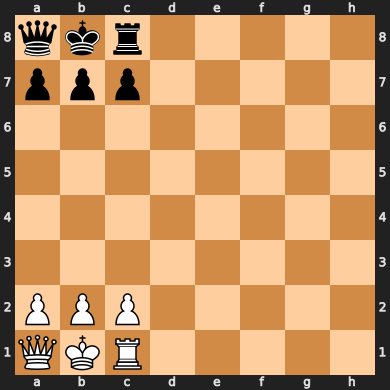

In [ ]:
# Create an empty board
board = chess.Board(None)  # no pieces

# Place 3 white pieces on the first row
board.set_piece_at(chess.A2, chess.Piece(chess.PAWN, chess.WHITE))
board.set_piece_at(chess.B2, chess.Piece(chess.PAWN, chess.WHITE))
board.set_piece_at(chess.C2, chess.Piece(chess.PAWN, chess.WHITE))

# Place 3 black pieces on the first row
board.set_piece_at(chess.A7, chess.Piece(chess.PAWN, chess.BLACK))
board.set_piece_at(chess.B7, chess.Piece(chess.PAWN, chess.BLACK))
board.set_piece_at(chess.C7, chess.Piece(chess.PAWN, chess.BLACK))


# Three offesnsive pieces white
board.set_piece_at(chess.A1, chess.Piece(chess.QUEEN, chess.WHITE))
board.set_piece_at(chess.B1, chess.Piece(chess.KING, chess.WHITE))
board.set_piece_at(chess.C1, chess.Piece(chess.ROOK, chess.WHITE))

# Three offesnive pieces black
board.set_piece_at(chess.A8, chess.Piece(chess.QUEEN, chess.BLACK))
board.set_piece_at(chess.B8, chess.Piece(chess.KING, chess.BLACK))
board.set_piece_at(chess.C8, chess.Piece(chess.ROOK, chess.BLACK))
print("8 Row 3 Column Board")
display(board)

In [ ]:
valid_squares = {chess.square(file, rank) for file in range(0, 3) for rank in range(0, 8)}
def is_valid_move(move):
    return move.from_square in valid_squares and move.to_square in valid_squares

# Simple material evaluator (White advantage positive)
piece_values = {
    chess.PAWN: 1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK: 5,
    chess.QUEEN: 9
}

def material_evaluate(board):
    """Return static material evaluation from White's perspective."""
    score = 0
    for piece, val in piece_values.items():
        score += val * (len(board.pieces(piece, chess.WHITE)) - len(board.pieces(piece, chess.BLACK)))
    return score

def outcome_from_board(board):
    """Return numeric outcome from White's perspective: 1=white win, 0=black win, 0.5 draw."""
    if board.is_checkmate():
        return 0.0 if board.turn == chess.WHITE else 1.0
    elif board.is_stalemate() or board.is_insufficient_material() or board.can_claim_draw():
        return 0.5
    else:
        # not terminal — use static eval to convert to probability in [0,1]
        # logistic mapping of material eval -> probability
        score = material_evaluate(board)
        prob = 1.0 / (1.0 + math.exp(-0.4 * score))  # scale factor tuned for small micro-chess
        return prob


In [ ]:
class MCTSNode:
    def __init__(self, board: chess.Board, parent=None, move=None):
        self.board = board
        self.parent = parent
        self.move = move                # move that led to this node (None for root)
        # children nodes list
        self.children = []
        self.visits = 0
        self.wins = 0.0                 # cumulative reward (White-perspective) aggregated by backprop
        # restrict moves to your valid_squares domain
        self.untried_moves = [m for m in board.legal_moves if is_valid_move(m)]

    def ucb1(self, exploration=1.4):
        """UCB1: returns +inf for unvisited nodes so they get tried."""
        if self.visits == 0:
            return float('inf')
        parent_vis = self.parent.visits if self.parent is not None else 1
        return (self.wins / self.visits) + exploration * math.sqrt(math.log(parent_vis) / self.visits)

    def best_child(self, exploration=1.4):
        """Return child with max UCB1; safe if no children."""
        if not self.children:
            return None
        return max(self.children, key=lambda c: c.ucb1(exploration))

    def expand(self):
        """Pop one untried move, apply it, create child node and return it."""
        if not self.untried_moves:
            return None
        move = self.untried_moves.pop()
        next_board = self.board.copy()
        next_board.push(move)
        child = MCTSNode(next_board, parent=self, move=move)
        self.children.append(child)
        return child

    def backpropagate(self, result):
        """
        result: numeric outcome from White's perspective (1 white win, 0 black, 0.5 draw)
        This node's wins counts the reward for the side that is to move at the parent's position?
        The method uses inversion when moving up the tree (consistent approach).
        """
        self.visits += 1
        self.wins += result
        if self.parent:
            # Invert result for opponent when moving up one ply
            self.parent.backpropagate(1.0 - result)

    def is_fully_expanded(self):
        return len(self.untried_moves) == 0

    def is_terminal(self):
        return self.board.is_game_over()

In [ ]:
def plot_mcts_stats(wins, visits):
    """Plot win rate & visit counts. X labels rotated 90 degrees."""
    moves = [m.uci() for m in wins.keys()]
    win_rates = [wins[m] / (visits[m] + 1e-12) for m in wins.keys()]
    visit_counts = [visits[m] for m in visits.keys()]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle("MCTS Diagnostics", fontsize=14)

    axes[0].bar(moves, win_rates, color='skyblue')
    axes[0].set_title("Estimated Win Rate per Move")
    axes[0].set_ylabel("Win rate (White perspective)")
    axes[0].tick_params(axis='x', rotation=90)

    axes[1].bar(moves, visit_counts, color='salmon')
    axes[1].set_title("Visit Count per Move")
    axes[1].set_ylabel("Visits")
    axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

In [ ]:
def rollout_policy(board, depth_limit=12):
    """
    Lightweight rollout:
    - prefer captures if available (simple heuristic)
    - otherwise random legal move
    - cutoff at depth_limit and then evaluate statically
    Returns numeric outcome from White perspective (1 white win, 0 black win, 0.5 draw OR probability from eval).
    """
    sim = board.copy()
    depth = 0
    while not sim.is_game_over() and depth < depth_limit:
        legal = [m for m in sim.legal_moves if is_valid_move(m)]
        if not legal:
            break
        # prefer captures to make rollouts more informative
        captures = [m for m in legal if sim.is_capture(m)]
        move = random.choice(captures) if captures else random.choice(legal)
        sim.push(move)
        depth += 1

    # If terminal, return exact outcome
    if sim.is_game_over():
        res = sim.result()
        if res == "1-0":
            return 1.0
        if res == "0-1":
            return 0.0
        return 0.5

    # non-terminal: map static material eval -> probability in (0,1)
    return outcome_from_board(sim)


In [ ]:
def mcts_move(board, simulations=800, exploration=1.4):
    """
    True MCTS:
      - Selection (UCB1)
      - Expansion (one child per iteration)
      - Simulation (rollout_policy)
      - Backpropagation
    Returns best_move (by visit count), plus diagnostic stats.
    """
    root = MCTSNode(board)

    # run simulations
    for _ in range(simulations):
        node = root

        # ----- Selection -----
        # go down using best_child while node fully expanded and non-terminal
        while node.is_fully_expanded() and not node.is_terminal():
            next_node = node.best_child(exploration)
            if next_node is None:
                break
            node = next_node

        # ----- Expansion -----
        if not node.is_terminal() and node.untried_moves:
            node = node.expand()

        # ----- Simulation -----
        result = rollout_policy(node.board)

        # ----- Backpropagation -----
        node.backpropagate(result)

    # gather stats from root's children
    wins = {}
    visits = {}
    for child in root.children:
        wins[child.move] = child.wins
        visits[child.move] = child.visits

    if wins:
        plot_mcts_stats(wins, visits)

    # choose best child by visit count (robust choice)
    if not root.children:
        return None, None, None
    best_child = max(root.children, key=lambda c: c.visits)
    best_move = best_child.move
    best_visits = best_child.visits
    best_wr = best_child.wins / (best_child.visits + 1e-12)
    print(f"\nMCTS chooses move: {best_move} | visits: {best_visits} | est. win prob (white): {best_wr:.3f}")
    return best_move, best_visits, best_wr


In [ ]:
def play_game(simulations_per_move=600):
    #board = chess.Board()
    mcts_thinking_times = []
    human_thinking_times = []

    while not board.is_game_over():
        print("\nCurrent board:")
        try:
            display(board)   # if in notebook; if not, you can use print(board)
        except NameError:
            print(board)

        if board.turn == chess.WHITE:
            s = datetime.now()
            print("Computer (MCTS) thinking...")
            move, visits, wr = mcts_move(board, simulations=simulations_per_move)
            e = datetime.now()
            mcts_thinking_times.append((e - s).total_seconds())

            if move is None:
                print("White has no legal moves. Game over.")
                break

            print(f"White (Computer) plays: {move.uci()}")
            board.push(move)

        else:
            s = datetime.now()
            legal_moves = [m for m in board.legal_moves if is_valid_move(m)]
            if not legal_moves:
                print("Black has no legal moves. Game over.")
                break

            print("Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit")
            print("Legal moves:", [m.uci() for m in legal_moves] + ['quit'])

            user_input = input("Your move: ").strip().lower()
            if user_input == "quit":
                print("Quitting.")
                break
            try:
                move = chess.Move.from_uci(user_input)
                if move in legal_moves:
                    board.push(move)
                else:
                    print("Invalid or out-of-domain move. Try again.")
                    continue
            except ValueError:
                print("Invalid UCI format. Try again.")
                continue
            e = datetime.now()
            human_thinking_times.append((e - s).total_seconds())

    print("\nFinal board:")
    try:
        display(board)
    except NameError:
        print(board)
    print("Game result:", board.result())



Current board:


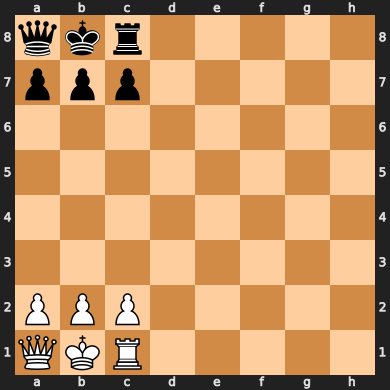

Computer (MCTS) thinking...


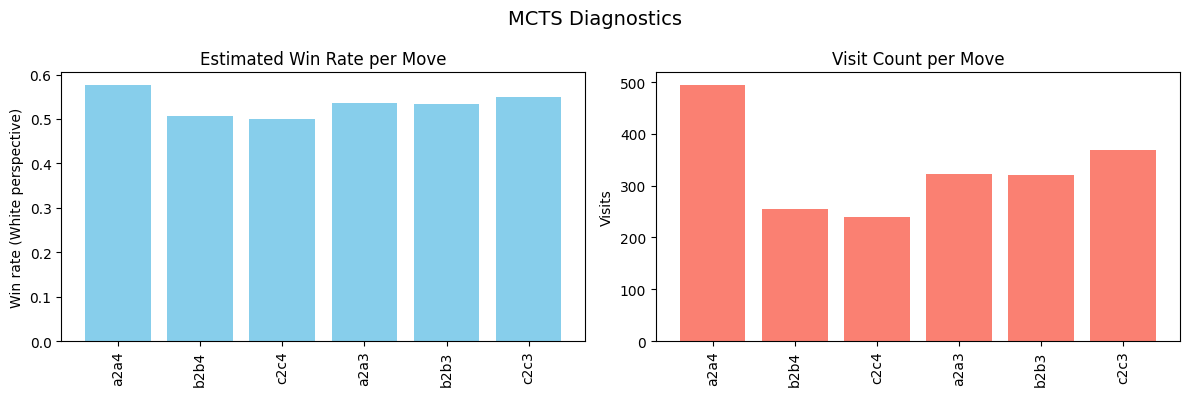


MCTS chooses move: a2a4 | visits: 494 | est. win prob (white): 0.576
White (Computer) plays: a2a4

Current board:


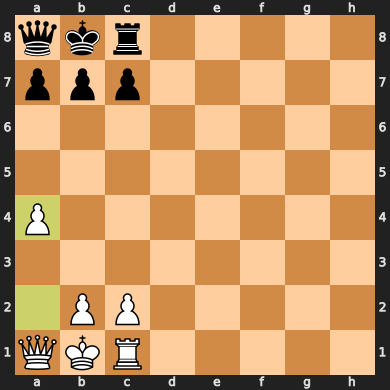

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['c7c6', 'b7b6', 'a7a6', 'c7c5', 'b7b5', 'a7a5', 'quit']
Your move: a7a5

Current board:


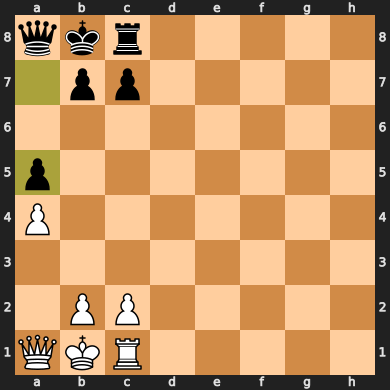

Computer (MCTS) thinking...


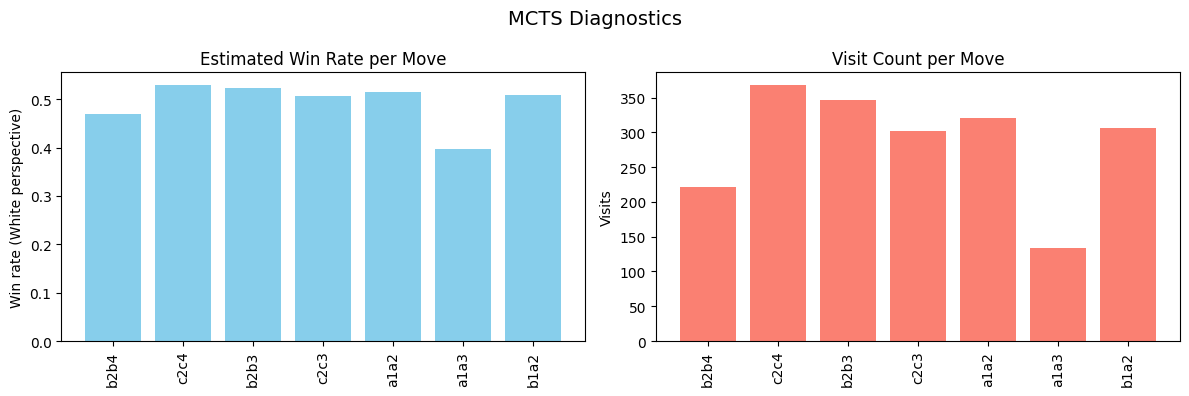


MCTS chooses move: c2c4 | visits: 368 | est. win prob (white): 0.529
White (Computer) plays: c2c4

Current board:


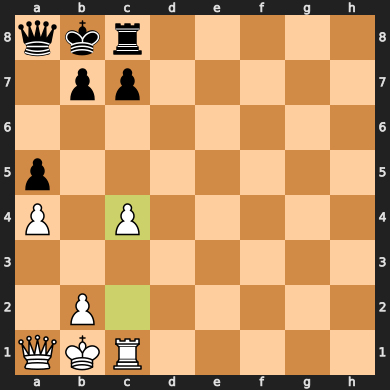

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8a7', 'a8a7', 'a8a6', 'c7c6', 'b7b6', 'c7c5', 'b7b5', 'quit']
Your move: c7c5

Current board:


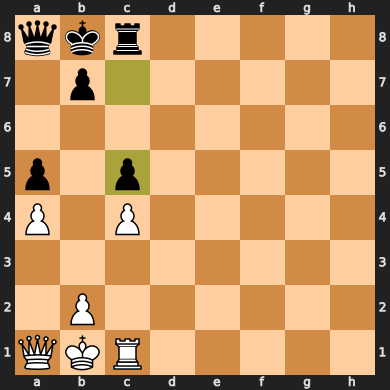

Computer (MCTS) thinking...


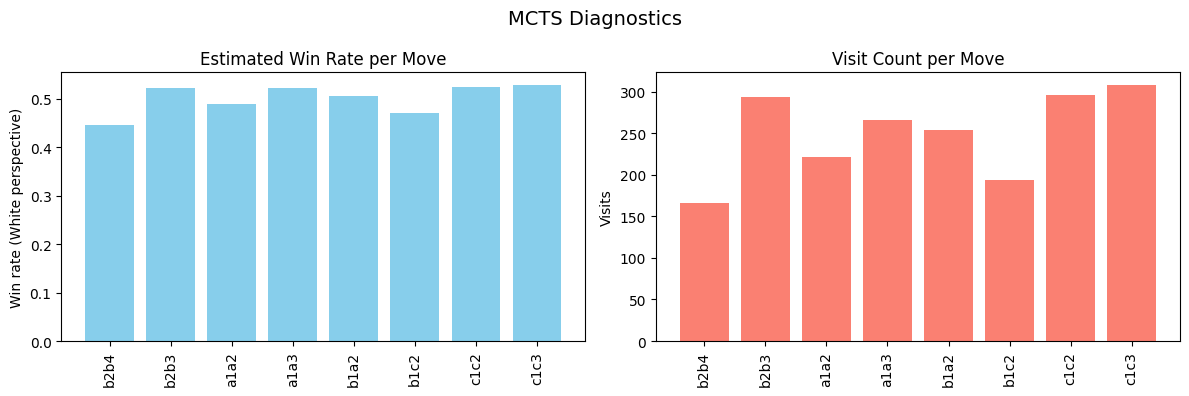


MCTS chooses move: c1c3 | visits: 308 | est. win prob (white): 0.528
White (Computer) plays: c1c3

Current board:


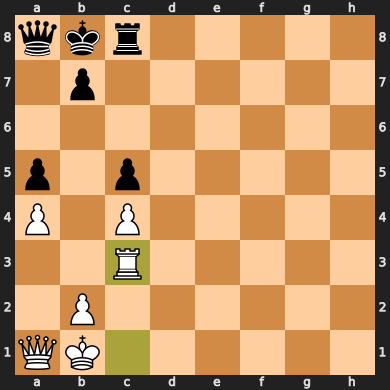

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['c8c7', 'c8c6', 'b8c7', 'b8a7', 'a8a7', 'a8a6', 'b7b6', 'b7b5', 'quit']
Your move: a8a6

Current board:


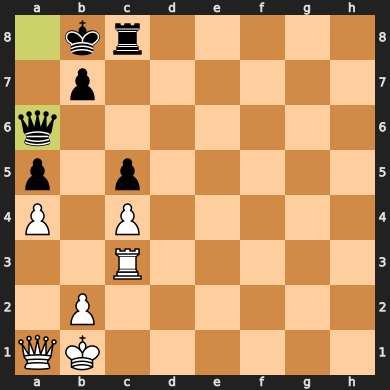

Computer (MCTS) thinking...


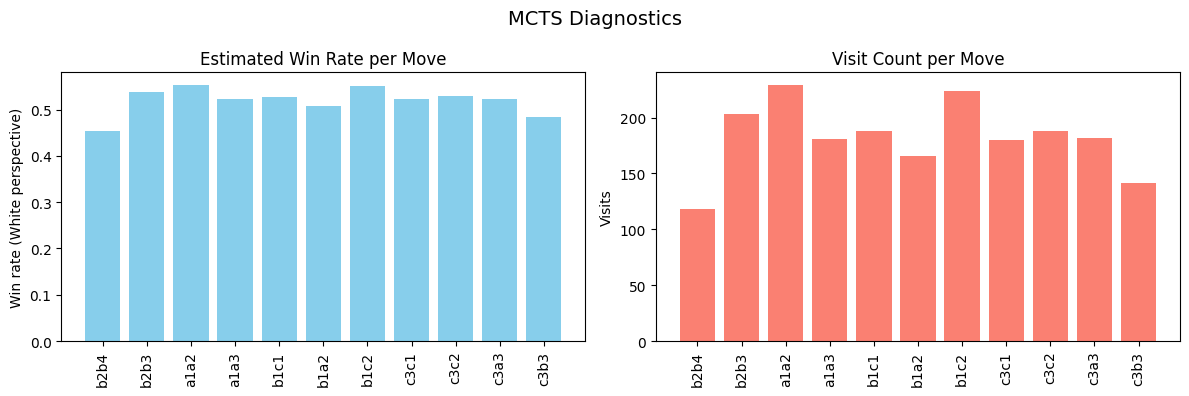


MCTS chooses move: a1a2 | visits: 229 | est. win prob (white): 0.553
White (Computer) plays: a1a2

Current board:


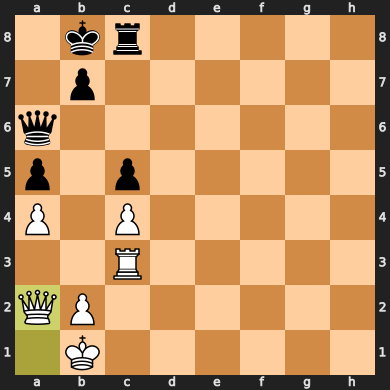

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['c8c7', 'c8c6', 'b8a8', 'b8c7', 'b8a7', 'a6a8', 'a6a7', 'a6c6', 'a6b6', 'a6b5', 'a6c4', 'b7b6', 'b7b5', 'quit']
Your move: c8c6

Current board:


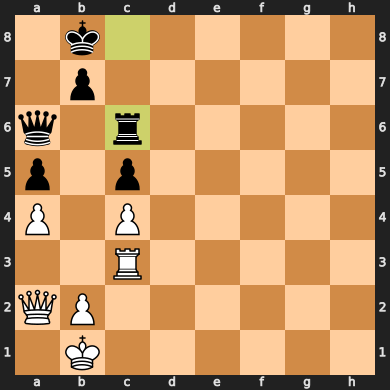

Computer (MCTS) thinking...


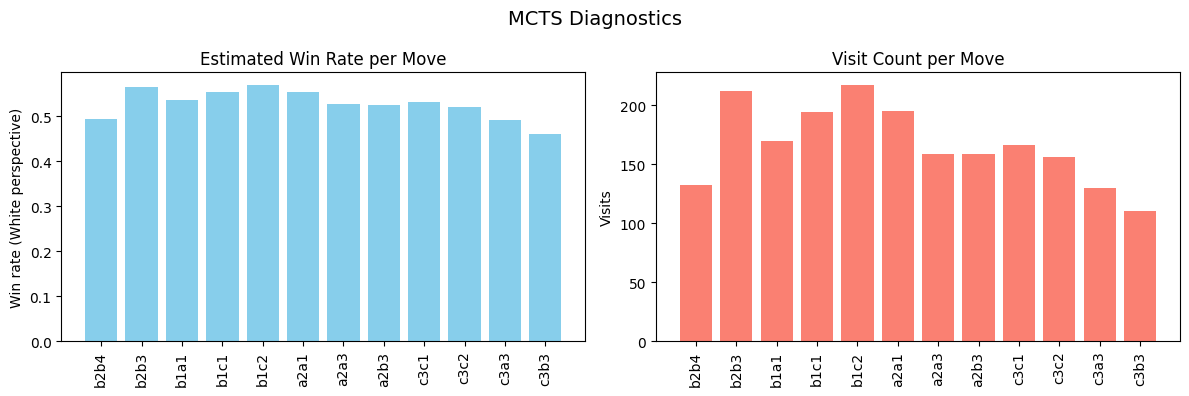


MCTS chooses move: b1c2 | visits: 217 | est. win prob (white): 0.570
White (Computer) plays: b1c2

Current board:


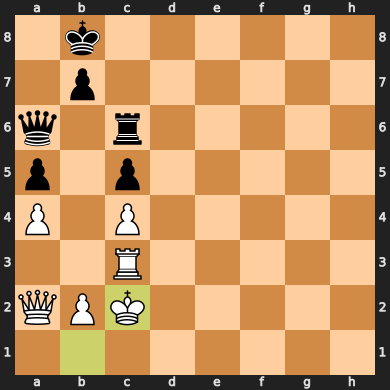

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8a8', 'b8c7', 'b8a7', 'c6c8', 'c6c7', 'c6b6', 'a6a8', 'a6a7', 'a6b6', 'a6b5', 'a6c4', 'b7b6', 'b7b5', 'quit']
Your move: b7b5

Current board:


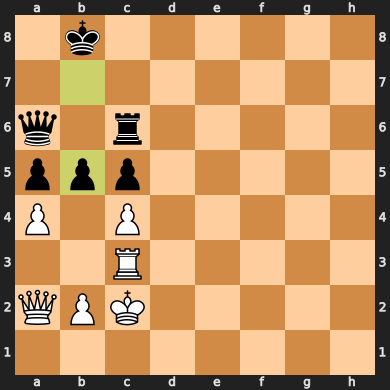

Computer (MCTS) thinking...


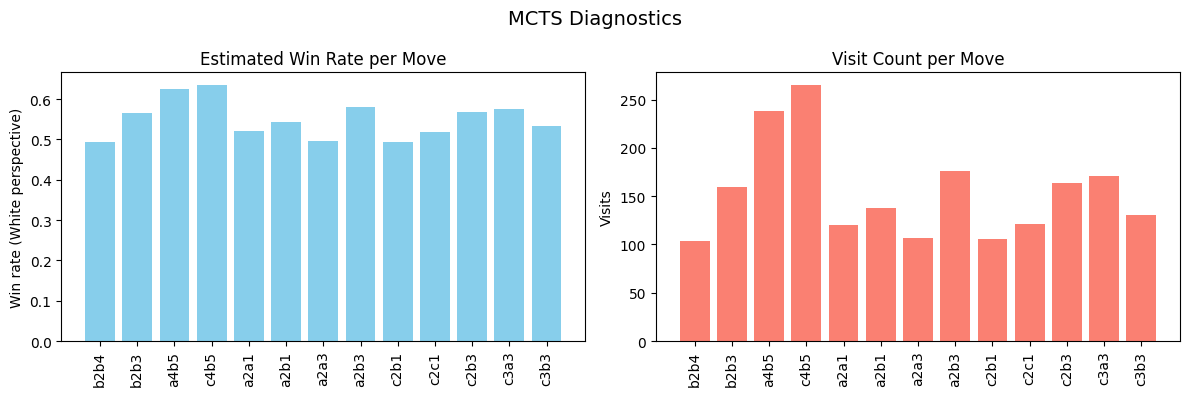


MCTS chooses move: c4b5 | visits: 265 | est. win prob (white): 0.635
White (Computer) plays: c4b5

Current board:


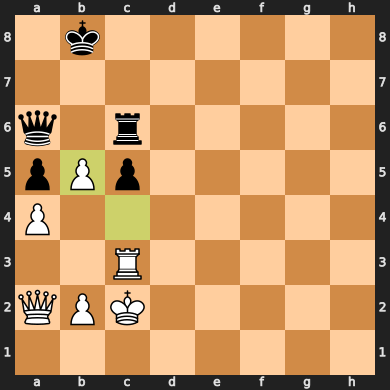

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8a8', 'b8c7', 'b8b7', 'b8a7', 'c6c8', 'c6c7', 'c6b6', 'a6c8', 'a6a8', 'a6b7', 'a6a7', 'a6b6', 'a6b5', 'c5c4', 'quit']
Your move: a6b5

Current board:


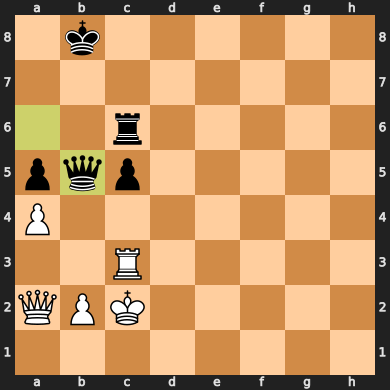

Computer (MCTS) thinking...


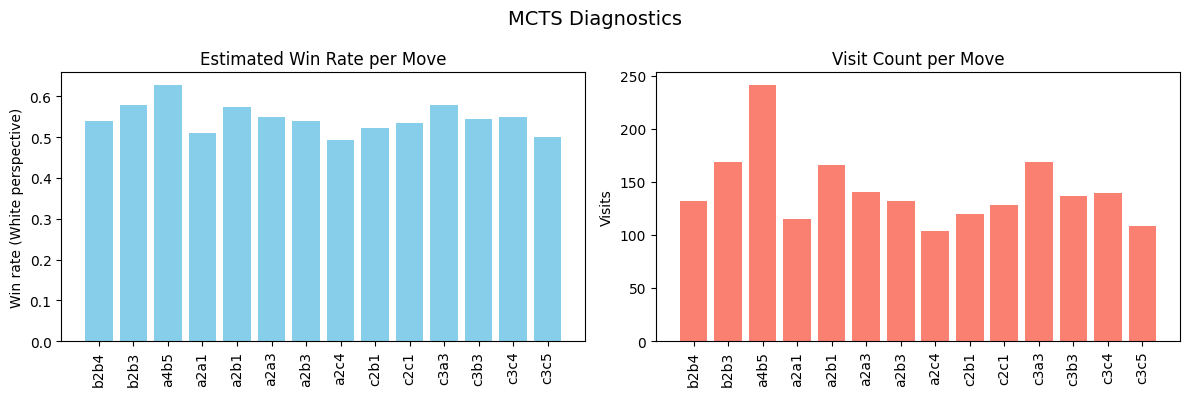


MCTS chooses move: a4b5 | visits: 241 | est. win prob (white): 0.628
White (Computer) plays: a4b5

Current board:


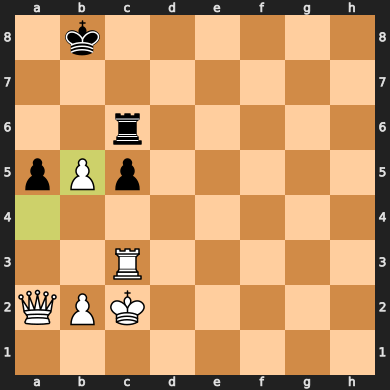

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8a8', 'b8c7', 'b8b7', 'b8a7', 'c6c8', 'c6c7', 'c6b6', 'c6a6', 'c5c4', 'a5a4', 'quit']
Your move: a5a3
Invalid or out-of-domain move. Try again.

Current board:


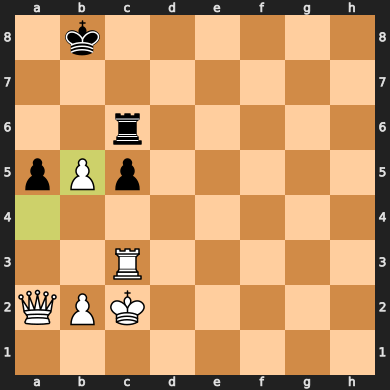

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8a8', 'b8c7', 'b8b7', 'b8a7', 'c6c8', 'c6c7', 'c6b6', 'c6a6', 'c5c4', 'a5a4', 'quit']
Your move: a5a4

Current board:


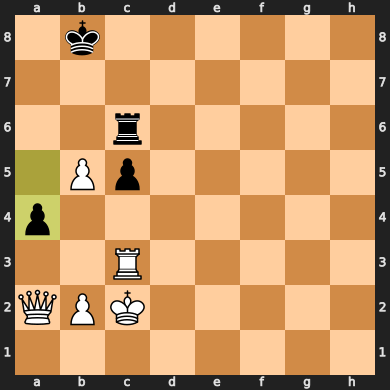

Computer (MCTS) thinking...


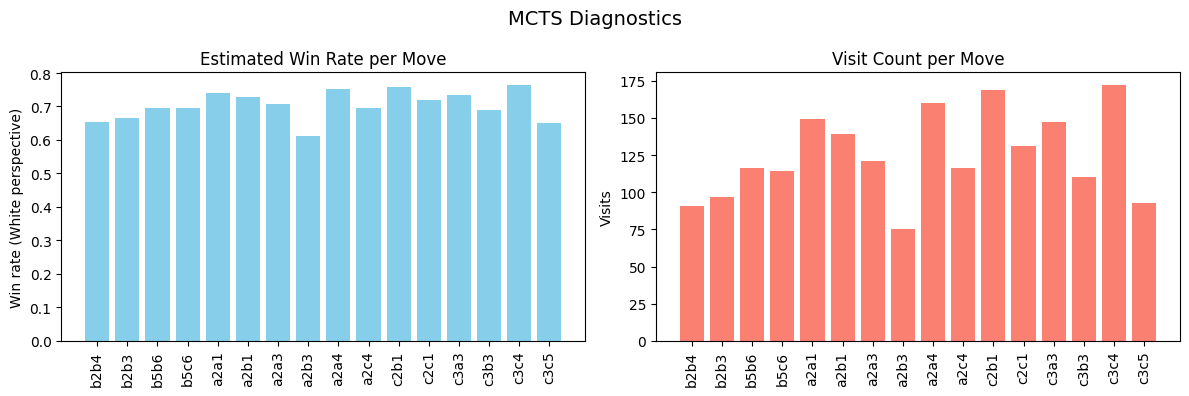


MCTS chooses move: c3c4 | visits: 172 | est. win prob (white): 0.764
White (Computer) plays: c3c4

Current board:


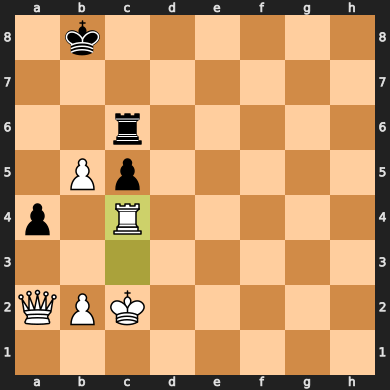

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8a8', 'b8c7', 'b8b7', 'b8a7', 'c6c8', 'c6c7', 'c6b6', 'c6a6', 'a4a3', 'quit']
Your move: b8c8

Current board:


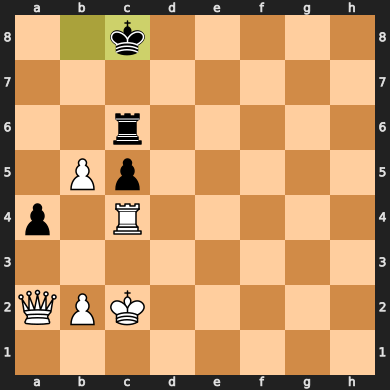

Computer (MCTS) thinking...


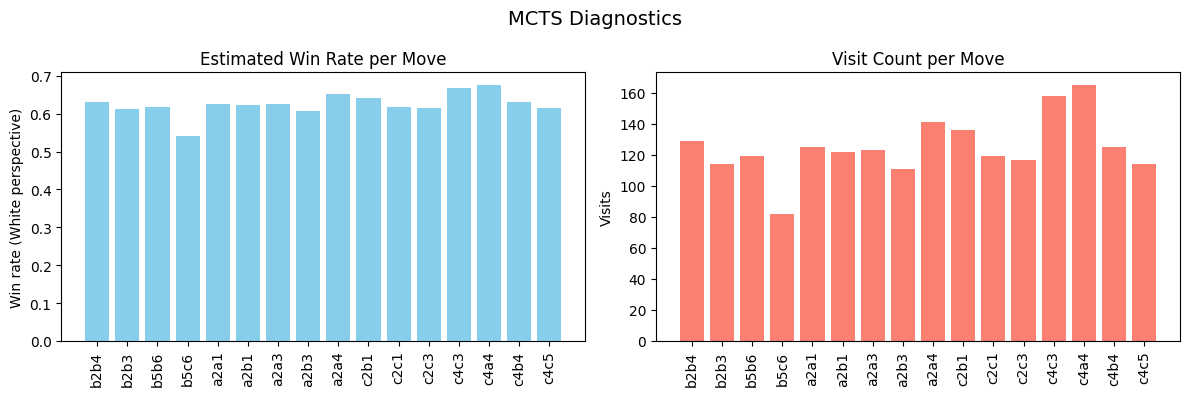


MCTS chooses move: c4a4 | visits: 165 | est. win prob (white): 0.675
White (Computer) plays: c4a4

Current board:


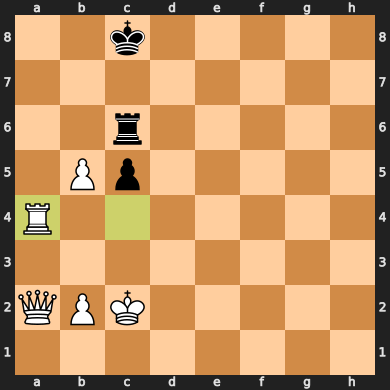

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['c8b8', 'c8c7', 'c8b7', 'c6c7', 'c6b6', 'c6a6', 'c5c4', 'quit']
Your move: c8b8

Current board:


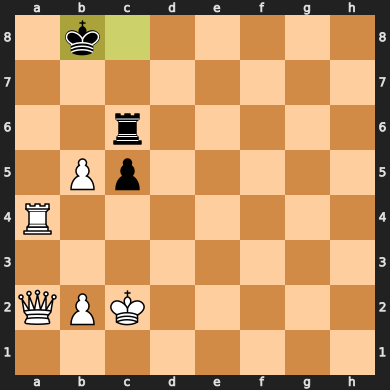

Computer (MCTS) thinking...


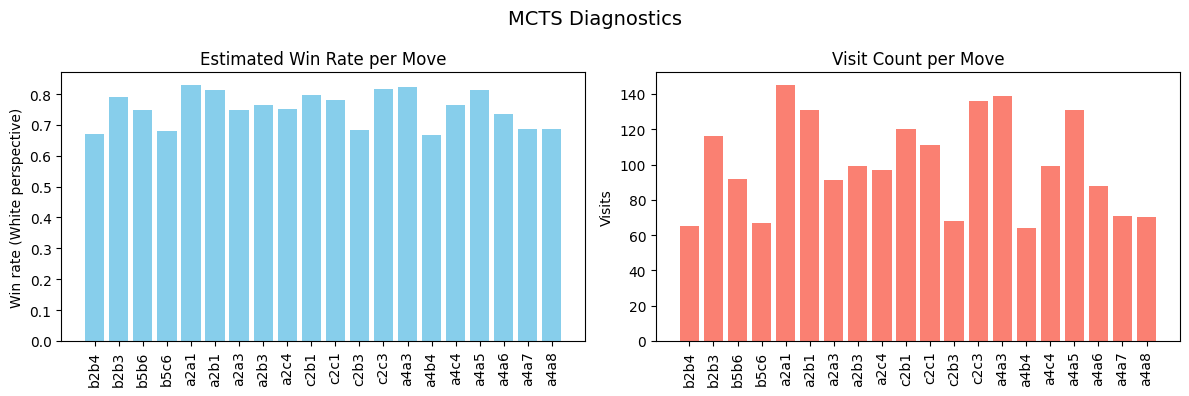


MCTS chooses move: a2a1 | visits: 145 | est. win prob (white): 0.829
White (Computer) plays: a2a1

Current board:


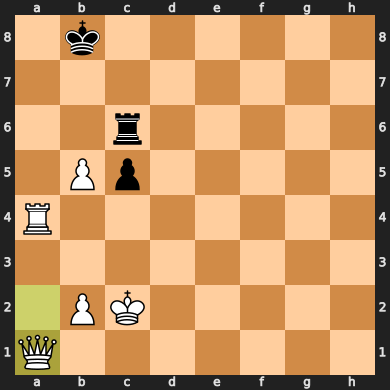

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8c7', 'b8b7', 'c6c8', 'c6c7', 'c6b6', 'c6a6', 'c5c4', 'quit']
Your move: c5c4

Current board:


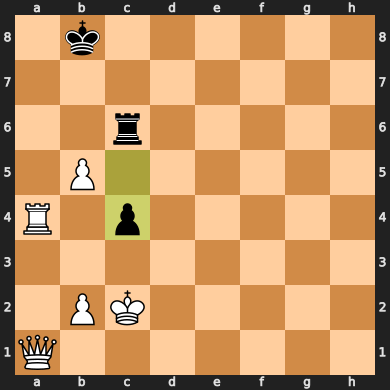

Computer (MCTS) thinking...


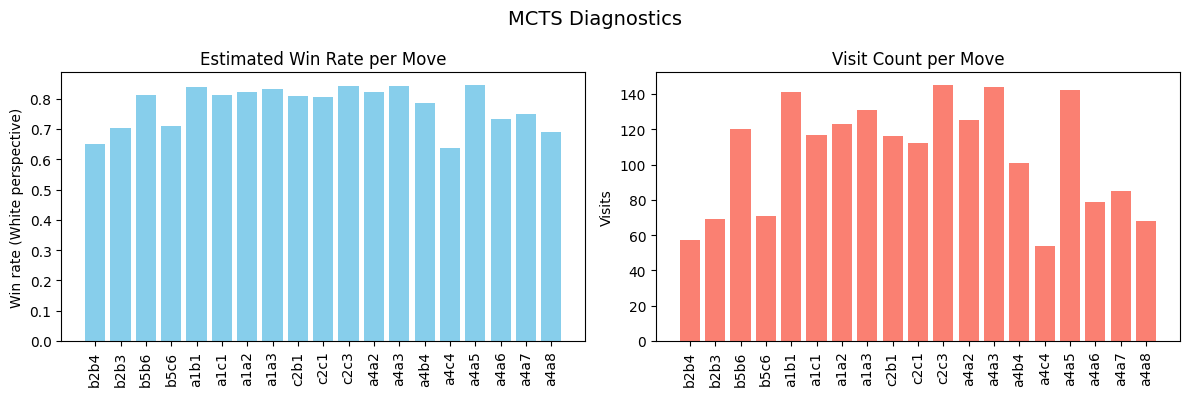


MCTS chooses move: c2c3 | visits: 145 | est. win prob (white): 0.843
White (Computer) plays: c2c3

Current board:


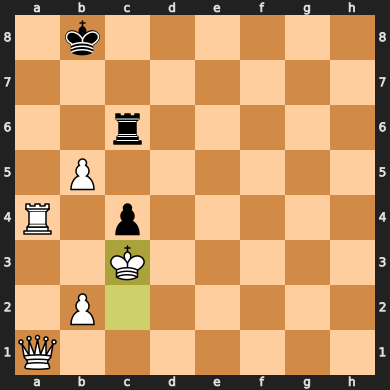

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8c7', 'b8b7', 'c6c8', 'c6c7', 'c6b6', 'c6a6', 'c6c5', 'quit']
Your move: c6c6
Invalid UCI format. Try again.

Current board:


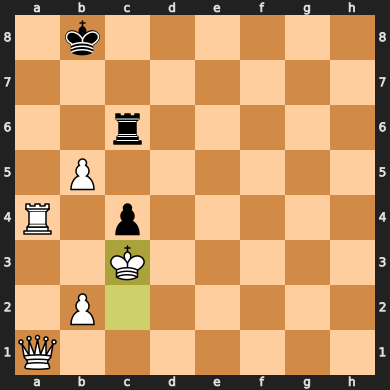

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8c7', 'b8b7', 'c6c8', 'c6c7', 'c6b6', 'c6a6', 'c6c5', 'quit']
Your move: c6b6

Current board:


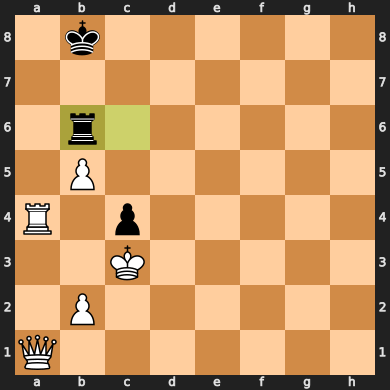

Computer (MCTS) thinking...


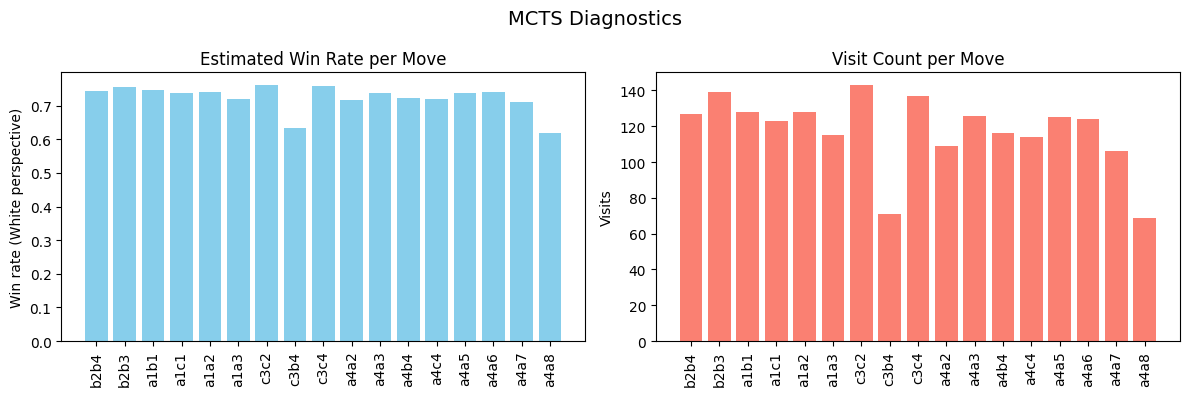


MCTS chooses move: c3c2 | visits: 143 | est. win prob (white): 0.761
White (Computer) plays: c3c2

Current board:


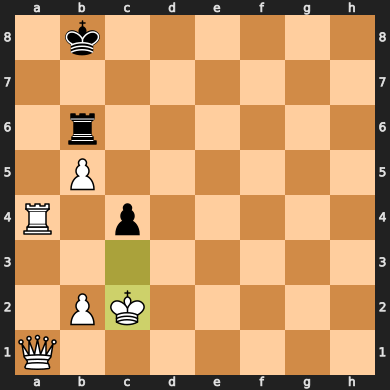

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8c7', 'b8b7', 'b6b7', 'b6c6', 'b6a6', 'b6b5', 'c4c3', 'quit']
Your move: b6a6

Current board:


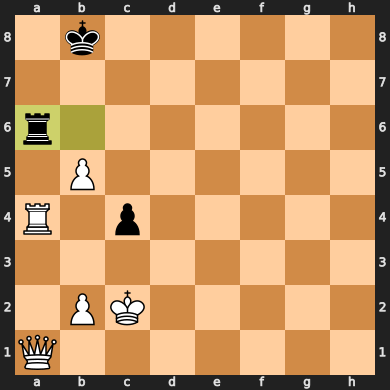

Computer (MCTS) thinking...


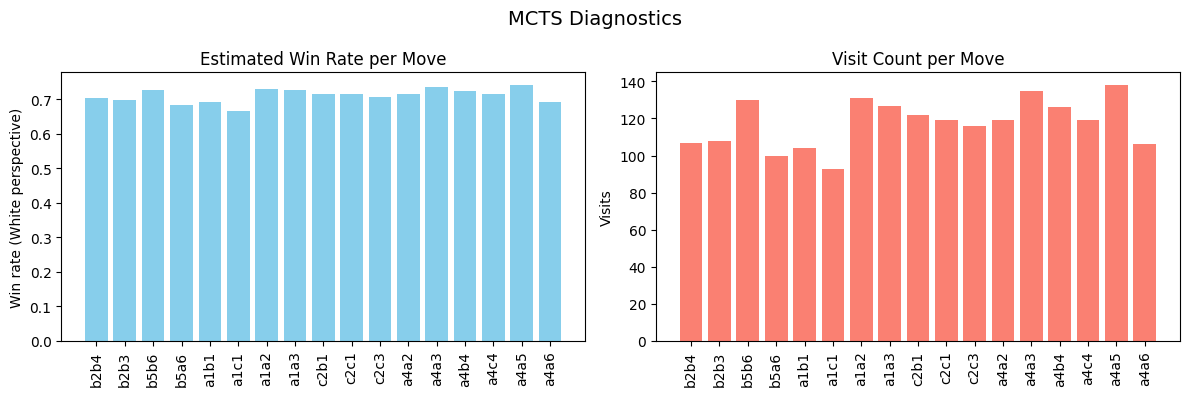


MCTS chooses move: a4a5 | visits: 138 | est. win prob (white): 0.741
White (Computer) plays: a4a5

Current board:


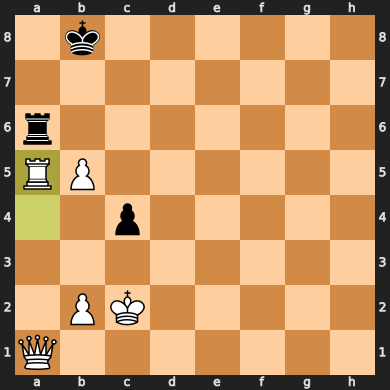

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8a8', 'b8c7', 'b8b7', 'b8a7', 'a6a8', 'a6a7', 'a6c6', 'a6b6', 'a6a5', 'c4c3', 'quit']
Your move: a6a5

Current board:


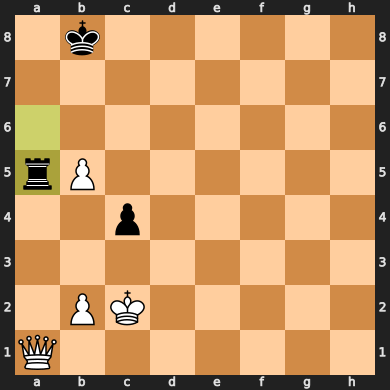

Computer (MCTS) thinking...


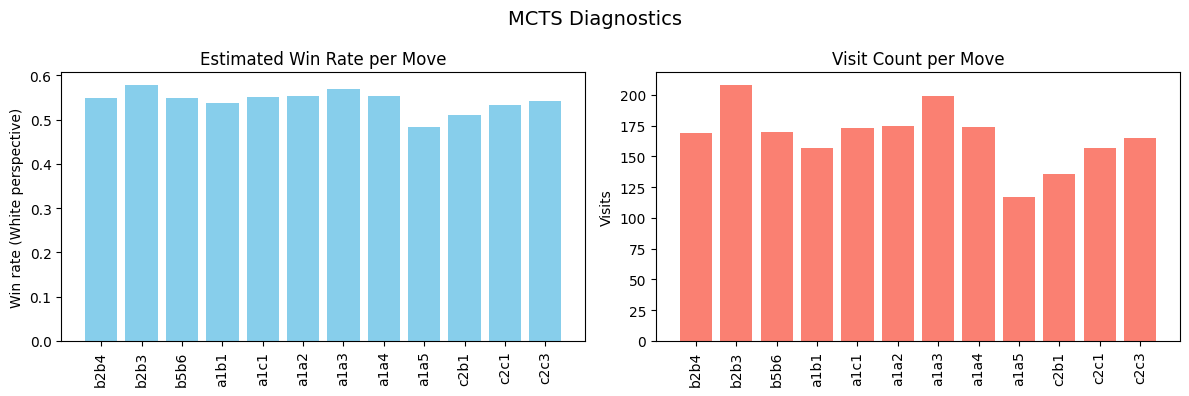


MCTS chooses move: b2b3 | visits: 208 | est. win prob (white): 0.578
White (Computer) plays: b2b3

Current board:


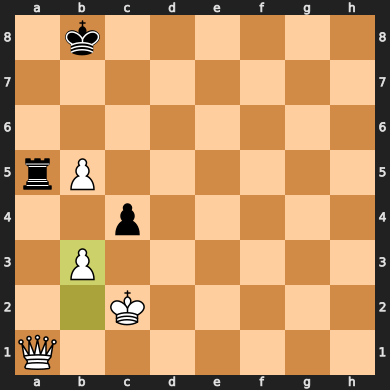

Your turn! Enter a move in UCI format (e.g., a7a6, b7b6, c7c6) or 'quit' to quit
Legal moves: ['b8c8', 'b8a8', 'b8c7', 'b8b7', 'b8a7', 'a5a8', 'a5a7', 'a5a6', 'a5b5', 'a5a4', 'a5a3', 'a5a2', 'a5a1', 'c4b3', 'c4c3', 'quit']


KeyboardInterrupt: Interrupted by user

In [ ]:
play_game(simulations_per_move=1000)